# Single Scenario Run Test Notebook

This notebook is designed to:
1. Select a specific scenario from `config.py`.
2. Perform a single Monte Carlo simulation for that scenario.
3. Fit the proposed Bayesian model using NumPyro (from your `sampler.py`).
4. Calculate benchmark CFR estimates (cCFR, aCFR).
5. Generate and display a time-series plot comparing true CFRs, 
   proposed model estimates (with 95% CrI and counterfactual), and benchmark estimates.

**Prerequisites:**
- All helper Python modules (`config.py`, `data_generation.py`, `benchmarks.py`, 
  `model_fitting.py`, `sampler.py`, `evaluation.py`, `results_io.py`, `plotting.py`) 
  must be in the same directory as this notebook or accessible in your `PYTHONPATH`.
- **`sampler.py` MUST be modified to accept `rng_key` as an argument in its `sample` function 
  for proper MCMC seeding.** #   (Example: def sample(..., rng_key=None): ... mcmc.run(rng_key, **data))

In [280]:
import pandas as pd
import numpy as np
import os
import time
import jax
from tqdm.auto import tqdm
import importlib
import matplotlib.pyplot as plt

# Import and force-reload all custom modules
import config; importlib.reload(config)
import data_generation; importlib.reload(data_generation)
import benchmarks; importlib.reload(benchmarks)
import evaluation; importlib.reload(evaluation)
import plotting; importlib.reload(plotting)
import tables; importlib.reload(tables)
import results_io; importlib.reload(results_io)
import model_fitting; importlib.reload(model_fitting)
import sampler; importlib.reload(sampler)

<module 'sampler' from 'C:\\Users\\user\\Desktop\\BICE-CFR\\BICE-CFR\\sampler.py'>

In [281]:
# --- 1. Select Scenario and Generate Data ---
scenario_to_test_id = "S12"
test_seed = 42

try:
    scenario_config = next(s for s in config.SCENARIOS if s['id'] == scenario_to_test_id)
except StopIteration:
    print(f"Error: Scenario '{scenario_to_test_id}' not found in config.py")

print(f"Generating data for scenario: {scenario_config['id']}...")
sim_data = data_generation.simulate_scenario_data(scenario_config, run_seed=test_seed)
print("Data generated successfully.")

Generating data for scenario: S12...
Data generated successfully.


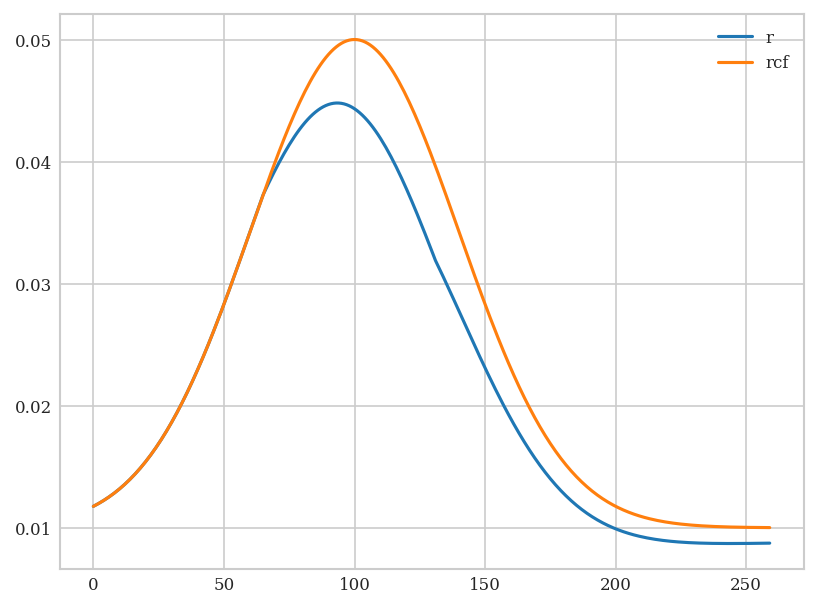

In [282]:
plt.plot(sim_data['true_r_0_t'],label="r")
plt.plot(sim_data['true_rcf_0_t'],label="rcf")
plt.legend()

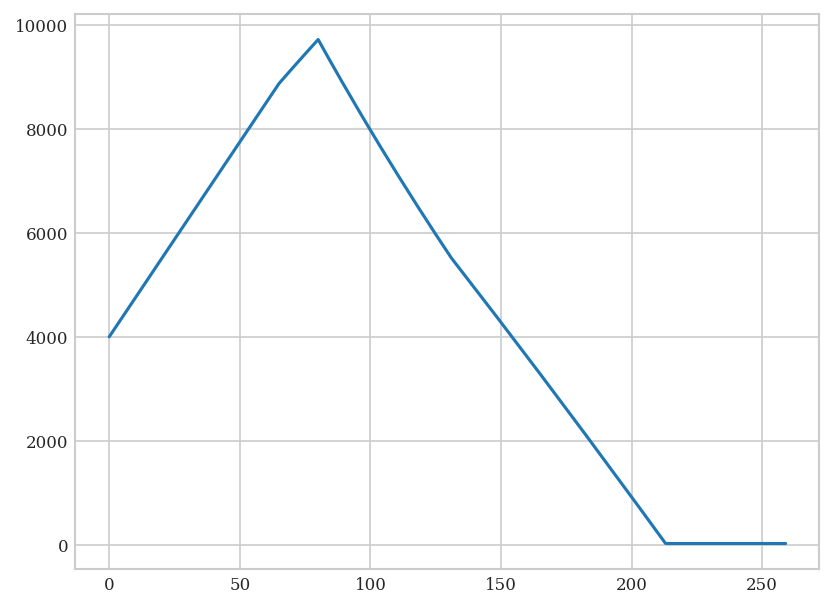

In [283]:
plt.plot(sim_data['c_t'])

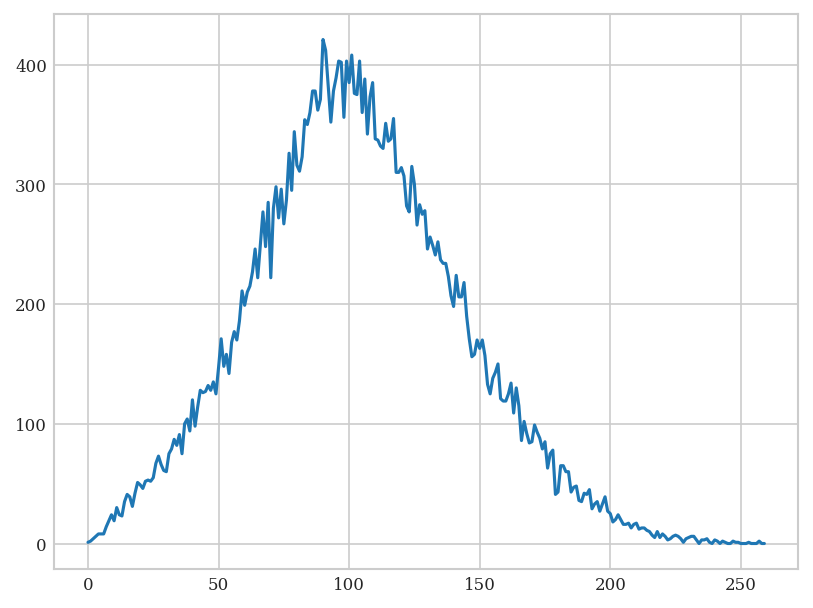

In [284]:
plt.plot(sim_data['d_t'])

In [285]:
# --- 2. Fit All Unconstrained Models ---
jax_prng_key = jax.random.PRNGKey(test_seed)

print("\nFitting sCFR model (unconstrained)...")
posterior_scfr, _ = model_fitting.fit_proposed_model(sim_data, jax_prng_key)

print("Fitting ITS benchmark model (unconstrained)...")
# Pass the original Bm and K_spline_obs to the ITS benchmark
its_results = benchmarks.calculate_its_with_penalized_mle(
    d_t=sim_data["d_t"], c_t=sim_data["c_t"], f_s=sim_data["f_s_true"],
    Bm=sim_data["Bm_true"],
    intervention_times_abs=sim_data["true_intervention_times_0_abs"],
    intervention_signs=sim_data["beta_signs_true"]
)
print("All models fitted successfully.")

# --- 3. Numerical Evaluation ---
print("\n--- Numerical Evaluation Results ---")
benchmarks_r_t = {
    "cCFR_cumulative": benchmarks.calculate_crude_cfr(sim_data["d_t"], sim_data["c_t"], cumulative=True),
    "aCFR_cumulative": benchmarks.calculate_nishiura_cfr_cumulative(sim_data["d_t"], sim_data["c_t"], sim_data["f_s_true"])
}
benchmark_cis = benchmarks.calculate_benchmark_cis_with_bayesian(sim_data["d_t"], sim_data["c_t"], sim_data["f_s_true"])
    
print("All models fitted successfully.")


Fitting sCFR model (unconstrained)...
Fitting ITS benchmark model (unconstrained)...
All models fitted successfully.

--- Numerical Evaluation Results ---
All models fitted successfully.


In [286]:
# Z_for_sampler = sim_data["Z_input_true"]
# if sim_data["num_interventions_true_K"] == 0:
#     Z_for_sampler = np.empty((sim_data["N_obs"], 0))
# data_init = model_fitting.get_ols_initial_values(
#     sim_data["Bm_true"],
#     Z_for_sampler,
#     sim_data["d_t"], 
#     sim_data["c_t"],
#     sim_data["K_spline_obs"],
#     sim_data["num_interventions_true_K"],
#     config.USE_CONSTRAINT
# )
# data_init

In [287]:
# Z_input_obs.shape

In [288]:
# Bm_obs = sim_data["Bm_true"]
# K_spline_obs = sim_data["K_spline_obs"]
# C_contrast = np.vstack([np.eye(K_spline_obs - 1), -np.ones((1, K_spline_obs - 1))])
# Bm_con = Bm_obs @ C_contrast
# combined_basis = Bm_con
# Z_input_obs = Z_for_sampler
# combined_basis = np.concatenate([combined_basis, Z_input_obs], axis=1)

# import seaborn as sn

# sn.heatmap(np.corrcoef(combined_basis))

In [289]:
# combined_basis = Bm_obs
# Z_input_obs = Z_for_sampler
# combined_basis = np.concatenate([combined_basis, Z_input_obs], axis=1)

# import seaborn as sn

# sn.heatmap(np.corrcoef(combined_basis))

In [290]:
# Collect all metrics
all_metrics = evaluation.collect_all_metrics(
    sim_data, posterior_scfr, 
    benchmarks_r_t, benchmark_cis, its_results
)

# Print the calculated metrics in a readable format
T_analyze = config.T_ANALYSIS_LENGTH
true_r_t_analysis = sim_data["true_r_0_t"][:T_analyze]
true_rcf_0_t_analysis = sim_data["true_rcf_0_t"][:T_analyze]

In [291]:
print("\n--- Parameter Estimation Metrics ---")
num_interventions = sim_data["num_interventions_true_K"]
if num_interventions > 0:
    # true_gammas = np.log(sim_data["true_beta_abs_0"] + 1e-9)
    true_beta_abs = sim_data["true_beta_abs_0"]
    true_lambdas = sim_data["true_lambda_0"]
    
    for k in range(num_interventions):
        # sCFR Metrics (beta_abs, lambda)
        print(f"--- sCFR (Intervention {k+1}) ---")
        print(f"  Beta_abs Bias:      {all_metrics.get(f'bias_beta_abs_{k+1}_sCFR', np.nan):.4f}")
        print(f"  Beta_abs CI Width:  {all_metrics.get(f'width_beta_abs_{k+1}_sCFR', np.nan):.4f}")
        print(f"  Beta_abs Coverage:  {all_metrics.get(f'cover_beta_abs_{k+1}_sCFR', 'N/A')}")
        print(f"  Lambda Bias:    {all_metrics.get(f'bias_lambda_{k+1}_sCFR', np.nan):.4f}")
        print(f"  Lambda Width:   {all_metrics.get(f'width_lambda_{k+1}_sCFR', np.nan):.4f}")
        print(f"  Lambda Coverage:{all_metrics.get(f'cover_lambda_{k+1}_sCFR', 'N/A')}")

        # ITS Metrics (beta_abs, lambda)
        print(f"\n--- ITS (Intervention {k+1}) ---")
        print(f"  Beta_abs Bias:      {all_metrics.get(f'bias_beta_abs_{k+1}_its', np.nan):.4f}")
        print(f"  Beta_abs CI Width:  {all_metrics.get(f'width_beta_abs_{k+1}_its', np.nan):.4f}")
        print(f"  Beta_abs Coverage:  {all_metrics.get(f'cover_beta_abs_{k+1}_its', 'N/A')}")
        print(f"  Lambda Bias:        {all_metrics.get(f'bias_lambda_{k+1}_its', np.nan):.4f}")
        print(f"  Lambda CI Width:    {all_metrics.get(f'width_lambda_{k+1}_its', np.nan):.4f}")
        print(f"  Lambda Coverage:    {all_metrics.get(f'cover_lambda_{k+1}_its', 'N/A')}")


--- Parameter Estimation Metrics ---
--- sCFR (Intervention 1) ---
  Beta_abs Bias:      -0.2471
  Beta_abs CI Width:  3.1378
  Beta_abs Coverage:  True
  Lambda Bias:    -0.2494
  Lambda Width:   2.7691
  Lambda Coverage:True

--- ITS (Intervention 1) ---
  Beta_abs Bias:      -1.0000
  Beta_abs CI Width:  0.0120
  Beta_abs Coverage:  False
  Lambda Bias:        1.1607
  Lambda CI Width:    0.0001
  Lambda Coverage:    False
--- sCFR (Intervention 2) ---
  Beta_abs Bias:      -0.1397
  Beta_abs CI Width:  3.1830
  Beta_abs Coverage:  True
  Lambda Bias:    -0.0894
  Lambda Width:   3.6283
  Lambda Coverage:True

--- ITS (Intervention 2) ---
  Beta_abs Bias:      -1.0000
  Beta_abs CI Width:  0.0005
  Beta_abs Coverage:  False
  Lambda Bias:        -1.0000
  Lambda CI Width:    0.0005
  Lambda Coverage:    False



Generating final comparison plot...

Comparison plot saved to: ./simulation_outputs/plots/test_single_run_scen_S12.pdf


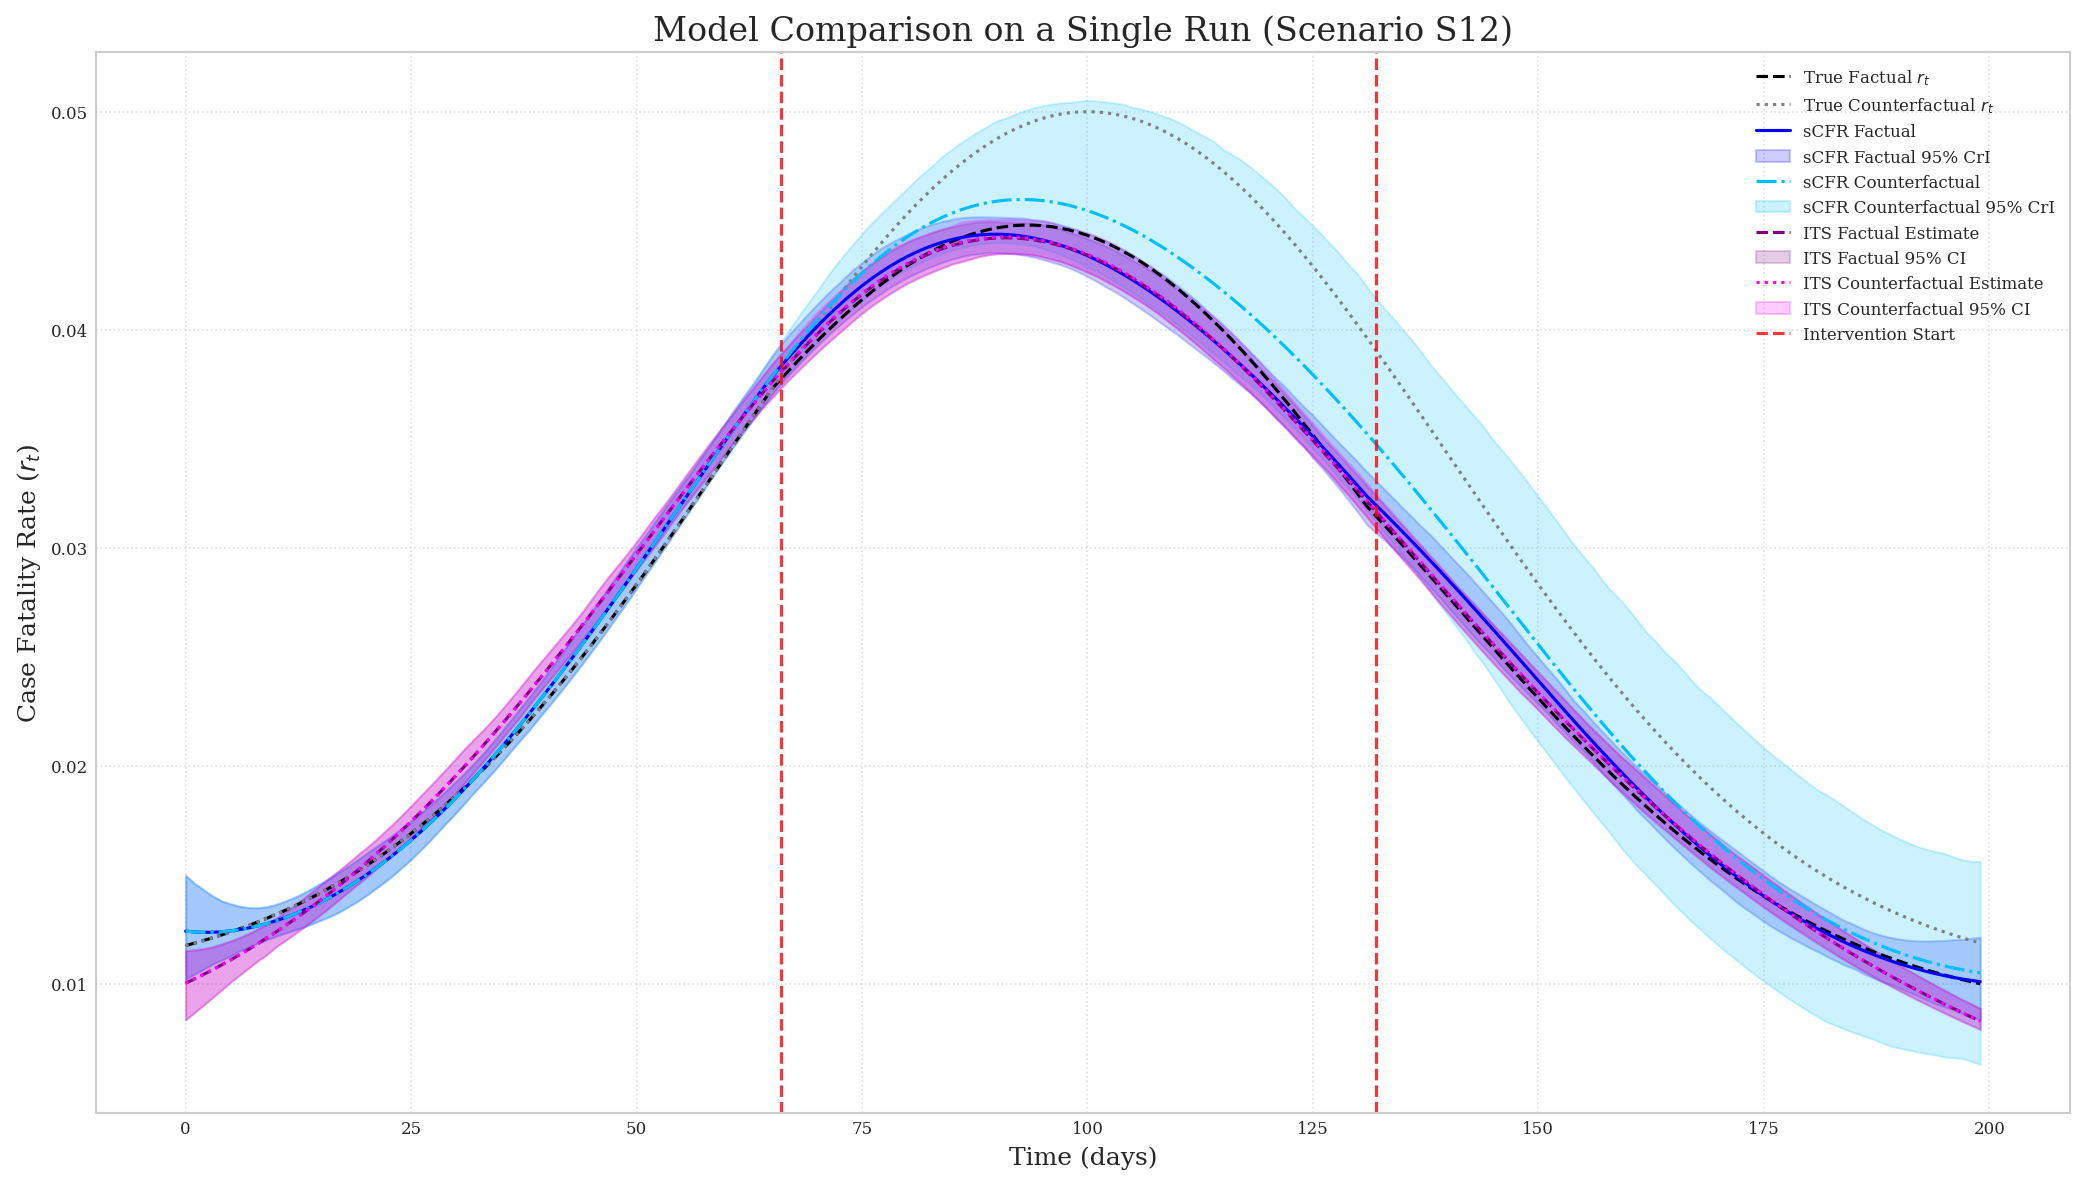

In [292]:
from scipy.special import logit, expit as sigmoid

print("\nGenerating final comparison plot...")
time_points = np.arange(T_analyze)

fig, ax = plt.subplots(figsize=(14, 8))

# Plot ground truth
ax.plot(time_points, true_r_t_analysis, color='black', linestyle='--', label="True Factual $r_t$")
ax.plot(time_points, true_rcf_0_t_analysis, color='gray', linestyle=':', label="True Counterfactual $r_t$")

scfr_p_mean, scfr_p_lower, scfr_p_upper = evaluation.get_posterior_estimates(posterior_scfr, "p")
ax.plot(time_points, scfr_p_mean[:T_analyze], color='blue', label="sCFR Factual")
ax.fill_between(time_points, scfr_p_lower[:T_analyze], scfr_p_upper[:T_analyze], 
                color='blue', alpha=0.2, label="sCFR Factual 95% CrI")

rcf_mean, rcf_lower, rcf_upper = evaluation.get_posterior_estimates(posterior_scfr, "p_cf")
ax.plot(time_points, rcf_mean[:T_analyze], color='deepskyblue', linestyle='-.', label="sCFR Counterfactual")
ax.fill_between(time_points, rcf_lower[:T_analyze], rcf_upper[:T_analyze], 
                color='deepskyblue', alpha=0.2, label="sCFR Counterfactual 95% CrI")

# Plot ITS benchmark
ax.plot(time_points, its_results["its_factual_mean"][:T_analyze], color='purple', linestyle='--', label="ITS Factual Estimate")
ax.fill_between(time_points, its_results["its_factual_lower"][:T_analyze], its_results["its_factual_upper"][:T_analyze], 
                color='purple', alpha=0.2, label="ITS Factual 95% CI")

ax.plot(time_points, its_results["its_counterfactual_mean"][:T_analyze], color='magenta', linestyle=':', label="ITS Counterfactual Estimate")
ax.fill_between(time_points, its_results["its_counterfactual_lower"][:T_analyze], its_results["its_counterfactual_upper"][:T_analyze], 
                color='magenta', alpha=0.2, label="ITS Counterfactual 95% CI")


intervention_times = sim_data["true_intervention_times_0_abs"]
for i, t_int in enumerate(intervention_times):
    if t_int < T_analyze:
        ax.axvline(x=t_int, color='red', linestyle='--', alpha=0.8, 
                   label=f"Intervention Start" if i == 0 else "")

# Final plot formatting
ax.set_title(f"Model Comparison on a Single Run (Scenario {scenario_to_test_id})", fontsize=16)
ax.set_xlabel("Time (days)", fontsize=12)
ax.set_ylabel("Case Fatality Rate ($r_t$)", fontsize=12)
ax.legend(loc='best')
ax.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()

output_dir = config.OUTPUT_DIR_PLOTS
os.makedirs(output_dir, exist_ok=True)
plot_filename = os.path.join(output_dir, f"test_single_run_scen_{scenario_to_test_id}.pdf")
plt.savefig(plot_filename)
print(f"\nComparison plot saved to: {plot_filename}")

plt.show()

In [272]:
sigmoid(logit(0.04)) - sigmoid(logit(0.04)-1)

0.024903099916446528